## A/B-тест

**Цель исследования** - провести оценку результатов A/B-теста.

Задачи:
- Оцените корректность проведения теста
- Проанализируйте результаты теста


Ход исследования:

**1. Обзор данных**
- Ознакомиться с данными в датасетах.
- Посмотреть общую информацию о датасетах.

**2. Предобработка данных**
- Проверить корректность типов данных.
- Проверить данные на дубликаты и пропуски. Описать природу этих данных, если они будут обнаружены.
- Оценить корректность проведения теста. Обратить внимание на:
    - Соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания.
    - Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения по тестовым группам и правильность их формирования.

**3. Исследовательский анализ данных**
- Узнать:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
   
**4. Оценка результатов A/B-тестирования**
- Что можно сказать про результаты A/В-тестирования?
- Проверьте статистическую разницу долей z-критерием.
    
**5. Общие выводы** 
- Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделать общее заключение о корректности проведения теста.

**Техническое задание:**
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## 1. Обзор данных

In [1]:
# настроим нашу тетрадку так, чтобы все графики были картинками (пригодится для github)
%pip install -U kaleido -q
import plotly.io as pio
pio.renderers.default = "png"

# импортируем библиотеки, необходимые для исследования

import pandas as pd
import datetime as dt
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
import math as mth
import warnings

Note: you may need to restart the kernel to use updated packages.


In [2]:
calendar, new_users, events, groups = (
    pd.read_csv('/Users/polinamokretsova/Downloads/ab_project_marketing_events.csv'), # календарь маркетинговых событий
    pd.read_csv('/Users/polinamokretsova/final_ab_new_users.csv'), # новые пользователи
    pd.read_csv('/Users/polinamokretsova/final_ab_events.csv'), # действия новых пользователей
    pd.read_csv('/Users/polinamokretsova/final_ab_participants.csv') # участники тестов
)

In [3]:
# выведем на экран поочередно первые строки каждого датафрэйма
calendar.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
groups.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [7]:
# поочередно посмотрим основную информацию о данным каждого датафрэйма
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [10]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Мы ознакомились с данными и посмотрели общую информацию о датафрэймах. Названия столбцов названы корректно, их исправлять нет необходимости.

Так же выделили моменты, которые нам необходимо будет исправить во время предобработки данных, а именно - изменить тип данных на временной:
   - в датафрэйме calendar: start_dt и finish_dt
   - в датафрэйме new_users: first_date
   - в датафрэйме events: event_dt

## 2. Предобработка данных

**Изменим тип данных на корректный**

In [11]:
calendar['start_dt'] = calendar['start_dt'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

calendar['finish_dt'] = calendar['finish_dt'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

new_users['first_date'] = new_users['first_date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

events['event_dt'] = pd.to_datetime(events['event_dt'])

In [12]:
# проверим, что тип данных изменился
calendar.info()
new_users.info()
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total

**Проверим данные на пропуски**

In [13]:
# поочередно проверим на пропуски каждый датафрэйм
calendar.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [14]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [15]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [16]:
groups.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Обнаружены пропуски в датафрэйме events, в переменной details. В этой переменной хранится дополнительная информация о событиях. Соответственно, наличие пропусков здесь - это нормально. Значит, далеко не у всех событий есть дополнительные данные.

**Проверим данные на дубликаты**

In [17]:
# поочередно проверим на дубликаты каждый датафрэйм
calendar.duplicated().sum()

0

In [18]:
new_users.duplicated().sum()

0

In [19]:
events.duplicated().sum()

0

In [20]:
groups.duplicated().sum()

0

Явных дубликатов не обнаружено.

**Мы провели предобработку данных:**
* Проверили данные на пропуски. Они были обнаружены в датафрэйме events, в переменной details. В этой переменной хранится дополнительная информация о событиях. Соответственно, наличие пропусков здесь - это нормально. Значит, далеко не у всех событий есть дополнительные данные.
* Явных дубликатов не обнаружено.

**Оценим данные на соответствие требованиям технического задания. Проверим корректность всех пунктов технического задания**

**Название теста: recommender_system_test**

In [21]:
groups['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Нас интересует только тест под названием "recommender_system_test". Данные о втором тесте удалим.

In [22]:
eu_groups = groups[groups['ab_test'] == 'recommender_system_test']

In [23]:
eu_groups['ab_test'].value_counts()

recommender_system_test    6701
Name: ab_test, dtype: int64

**Группы: А — контрольная, B — новая платёжная воронка**

In [24]:
eu_groups['group'].unique()

array(['A', 'B'], dtype=object)

В наших данных только две группы: контрольная и новая платёжная воронка.

**Дата запуска: 2020-12-07**

In [25]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

Первые события были зафиксированы в день начала теста - 7 декабря 2020 года.

**Дата остановки набора новых пользователей: 2020-12-21**

In [26]:
# самая ранняя дата регистрации
print('Самая ранняя дата регистрации:', new_users['first_date'].min())

Самая ранняя дата регистрации: 2020-12-07 00:00:00


In [27]:
# самая поздняя дата регистрации
print('Самая поздняя дата регистрации:', new_users['first_date'].max())

Самая поздняя дата регистрации: 2020-12-23 00:00:00


Мы рассматриваем только тех пользователей, кто зарегистрировался до 21 декабря включительно. Пользователей, которые зарегистрировались позже, отсекаем. 

In [28]:
new_users = new_users[new_users['first_date'] < '2020-12-22']

In [29]:
# проверим сейчас самую познюю дату регистрации
print('Самая поздняя дата регистрации:', new_users['first_date'].max())

Самая поздняя дата регистрации: 2020-12-21 00:00:00


**Дата остановки теста: 2021-01-04**

In [30]:
print('Дата последнего события:', events['event_dt'].max())

Дата последнего события: 2020-12-30 23:36:33


Дата последнего зафиксированного события - 30 декабря. Значит, тест был завершён раньше, чем было указано в ТЗ. Соответственно, результат может быть некорретным, т.к. не было соблюдено требование о завершении теста 4 января.
  
  В техническом задании также сказано, что мы смотрим результат за 14 дней с момента регистрации пользователей, значит, некоторые пользователи не будут иметь возможности совершать события все 14 дней. В таком случае, у нас у разных пользователей будет разный горизонт событий, что может сказаться на количестве событий на пользователя, на дневной активности и на гланвый результат теста.

**Аудитория: 15% новых пользователей из региона EU**

In [31]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [32]:
# посчитаем, сколько всего пользователей из Евросоюза в наших данных
eu_users = new_users[new_users['region'] == 'EU']
eu_users_id = eu_users['user_id'].unique()
print('Всего новых пользователей из Евросоюза:', eu_users['user_id'].nunique())

Всего новых пользователей из Евросоюза: 42340


In [33]:
# посчитаем, сколько пользователей из Евросоюза участвовали в тесте
eu_users_test = eu_groups.query('user_id in @eu_users_id')
print('Всего новых пользователей из Евросоюза - участников теста:', eu_users_test['user_id'].nunique())

Всего новых пользователей из Евросоюза - участников теста: 6351


In [34]:
# посчитаем процент пользователей из Евросоюза, которые участвовали в тесте, от общего количества пользователей Евросоюза
perc = (eu_users_test['user_id'].nunique()/eu_users['user_id'].nunique())*100
print('Аудитория теста составила', perc,'% новых пользователей из региона EU.')

Аудитория теста составила 15.0 % новых пользователей из региона EU.


**Ожидаемое количество участников теста: 6000**

In [35]:
print('Количество участников теста:', eu_users_test['user_id'].nunique())

Количество участников теста: 6351


Мы проверили наши данные на соответствие техническому заданию и вот, что выяснили: 
- В наших данных была информация о двух тестах. Но нас интересует только тест под названием "recommender_system_test". Данные о втором тесте удалили.
- В наших данных только две группы: контрольная (А) и новая платёжная воронка (B).
- Первые события были зафиксированы в день начала теста - 7 декабря 2020 года. Это совпадает с датой запуска теста.
- Пользователи в наших данных регистрировались до 23 декабря 2020, но нас интересовала крайняя дата регистрации - 21 декабря 2020 года. Пользователей, которые не соответствовали, мы убрали из анализа.
- Дата последнего зафиксированного события - 30 декабря. Значит, тест был завершён раньше, чем было указано в ТЗ.
- Аудитория теста составила 15.0 % новых пользователей из региона EU.
- Количество участников теста: 6351.

Далее мы проверим и другие параметры, так что картина может измениться.

**Проверим время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями**

In [36]:
eu_events = events.merge(eu_users_test, on='user_id')
eu_events

,user_id,event_dt,event_name,details,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test
...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,A,recommender_system_test
23416,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,B,recommender_system_test
23417,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,B,recommender_system_test
23418,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test


Мы знаем, что в наших данных события, происходящие в даты: 7 - 21 декабря. Теперь посмотрим, какие маркетинговые и другие активности происходили в Евросоюзе и проверим, нет ли пересечений.

In [37]:
# отберем только те маркетинговые события, которые относились к Евросоюзу
calendar[calendar['regions'].str.contains("EU")]
calendar.query('regions.str.contains("EU")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


В период с 25 декабря 2020 года по 3 января 2021 года проходило - Christmas&New Year Promo. Проверим, как данное мероприятие повлияло на поведение пользователей.

**Посмотрим, как новогодняя акция повлияла на поведение пользователей в общем**

In [38]:
# разделим пользователей на группы
groupA = eu_events[eu_events['group']=='A']
groupB = eu_events[eu_events['group']=='B']

In [39]:
# выделяем дату, без времени
warnings.filterwarnings("ignore")
groupA['date'] = groupA['event_dt'].astype('datetime64[D]') 
groupB['date'] = groupB['event_dt'].astype('datetime64[D]') 

In [40]:
# считаем количество событий в день в каждой группе
actions_per_dayA = groupA.groupby('date')['event_name'].count().to_frame().reset_index()
actions_per_dayB = groupB.groupby('date')['event_name'].count().to_frame().reset_index()

In [41]:
# объединяем две группы в одну табличку
actions_per_day = actions_per_dayA.merge(actions_per_dayB, on='date')
actions_per_day.columns = ['date', 'group_A', 'group_B']
actions_per_day

,date,group_A,group_B
0,2020-12-07,318,356
1,2020-12-08,313,238
2,2020-12-09,371,338
3,2020-12-10,331,249
4,2020-12-11,356,161
5,2020-12-12,346,199
6,2020-12-13,308,164
7,2020-12-14,1015,248
8,2020-12-15,1030,222
9,2020-12-16,1007,369


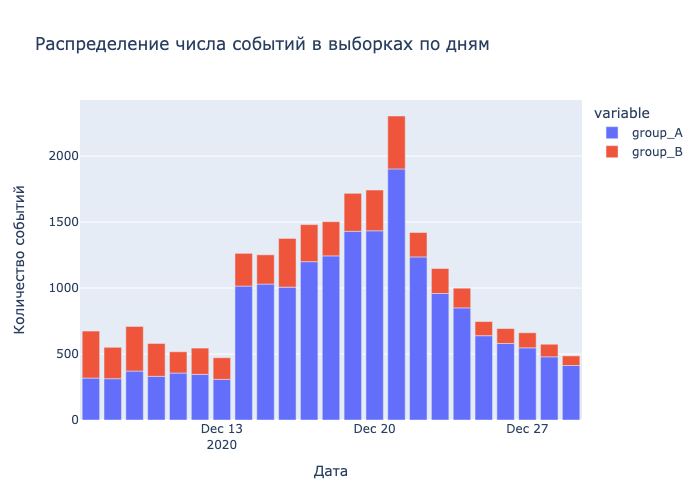

In [42]:
fig = px.bar(actions_per_day, x="date", y=["group_A", "group_B"], title="Распределение числа событий в выборках по дням",
            labels={'value': 'Количество событий', 'date': 'Дата'})
fig.show()

**Посмотрим, как новогодняя акция повлияла на покупки**

In [43]:
purchaseA = groupA[groupA['event_name'] == 'purchase']
purchaseB = groupB[groupB['event_name'] == 'purchase']

In [44]:
purchases_per_dayA = purchaseA.groupby('date')['event_name'].count().to_frame().reset_index()
purchases_per_dayB = purchaseB.groupby('date')['event_name'].count().to_frame().reset_index()

In [45]:
purchases_per_day = purchases_per_dayA.merge(purchases_per_dayB, on='date')
purchases_per_day.columns = ['date', 'group_A', 'group_B']
purchases_per_day

,date,group_A,group_B
0,2020-12-07,43,59
1,2020-12-08,33,33
2,2020-12-09,47,39
3,2020-12-10,42,26
4,2020-12-11,40,16
5,2020-12-12,38,25
6,2020-12-13,32,26
7,2020-12-14,133,32
8,2020-12-15,137,32
9,2020-12-16,142,50


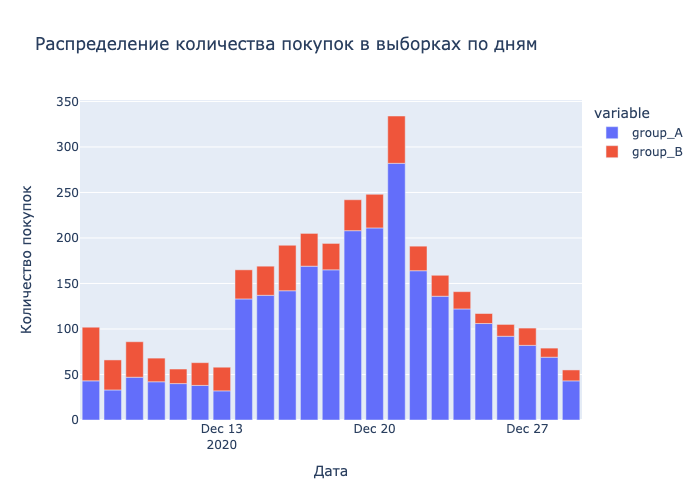

In [46]:
fig = px.bar(purchases_per_day, x="date", y=["group_A", "group_B"], title="Распределение количества покупок в выборках по дням",
            labels={'value': 'Количество покупок', 'date': 'Дата'})
fig.show()

Несмотря на новогоднюю акцию, общее количество событий и оличество покупок шло на спад в обоих группах. Значит, маркетинговое событие, которое происходило параллельно с тетом, не повлияло на поведение пользователей.

**Проверим аудиторию теста**

**Удостоверимся, нет ли пересечений пользователей нашего теста с конкурирующим**

In [47]:
eu_user_id = eu_events['user_id'].unique() # сохраним в переменную уникальные id пользователей нашего теста

In [48]:
another_test = groups[groups['ab_test'] == 'interface_eu_test']
another_user_id = another_test['user_id'].unique() # сохраним в переменную уникальные id пользователей конкурирующего теста

In [49]:
# проверим пересекаются ли пользователи
general_users = groups.loc[groups['user_id'].isin(eu_user_id)& groups['user_id'].isin(another_user_id),'user_id'].unique()
print(len(general_users))

887


Получается, 887 пользователей попали и в наш тест, и в конкурирующий. Логично было бы удалить их из нашего теста.

**Посмотрим, сколько пользователей у нас осталось, после отсечения**

In [50]:
eu_events = eu_events.query("user_id not in @general_users")

In [51]:
eu_events['user_id'].nunique()

2594

У нас осталось всего 2594 уникальных пользователей. Это говорит о том, что данные не соответствуют техническому заданию. Это отразится на результатах анализа A/B-теста.

**Проверим, нет ли пользователей, участвующих в двух группах нашего теста сразу**

In [52]:
# создадим переменные, в которые сохраним ID пользователей в каждой группе
usersA = eu_events[eu_events['group']=='A']['user_id']
usersB = eu_events[eu_events['group']=='B']['user_id']

# а теперь посмотрим, есть ли одни и те же пользователи, которые попали в обе группы сразу
usersAB = eu_events.loc[eu_events['user_id'].isin(usersA)& eu_events['user_id'].isin(usersB),'user_id'].unique()
print(len(usersAB))

0


Внутри групп нашего теста пользователи не пересекаются.

**Проверим равномерность распределения по тестовым группам и правильность их формирования**

In [53]:
eu_events.groupby(by='group')['user_id'].nunique()

group
A    1939
B     655
Name: user_id, dtype: int64

После того, как мы провели предобработку и проверку на корректность формирования групп теста, мы выяснили, что:
- в группе A 1939 пользователей 
- в группе B 655 пользователей

Количество пользователей во второй группе почти в 2,8 раз меньше, чем в первой группе. Наши группы неравномерны, сформированы некорректно.

Конверсия в группе А - 31,6%. По ТЗ группа В должна показать различие конверсии в 10%. Для этого выборки должны быть по 3,360 пользователей в каждой группе. В нашем тесте и та, и другая выборка содержит меньше пользователей. Значит, мощности теста недостаточно. Это отразится на результате тестирования.

**Рассчитаем лайфтайм каждого события и отбросим те, что старше 14 дней с момента регистрации**

In [54]:
eu_events = eu_events.merge(eu_users, how='left', on='user_id')
eu_events['event_dt'] = eu_events['event_dt'].astype('datetime64[D]')
eu_events['lifetime'] = eu_events['event_dt'] - eu_events['first_date']
eu_events

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,lifetime
0,831887FE7F2D6CBA,2020-12-07,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0 days
1,831887FE7F2D6CBA,2020-12-09,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android,2 days
2,831887FE7F2D6CBA,2020-12-07,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,0 days
3,831887FE7F2D6CBA,2020-12-08,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,1 days
4,831887FE7F2D6CBA,2020-12-09,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2 days
...,...,...,...,...,...,...,...,...,...,...
17521,64597B30278462F5,2020-12-23,login,NaN,A,recommender_system_test,2020-12-21,EU,Android,2 days
17522,1484BBF124DB1B18,2020-12-21,login,NaN,A,recommender_system_test,2020-12-21,EU,PC,0 days
17523,1484BBF124DB1B18,2020-12-22,login,NaN,A,recommender_system_test,2020-12-21,EU,PC,1 days
17524,1484BBF124DB1B18,2020-12-27,login,NaN,A,recommender_system_test,2020-12-21,EU,PC,6 days


In [55]:
eu_events['event_name'].count()

17526

In [56]:
eu_events = eu_events[eu_events['lifetime'] <= '14 days']

In [57]:
eu_events['event_name'].count()

17087

Мы удалили 439 событий, которые не удовлетворяли условию: событие не должно быть старше 14 дней с момента регистрации.

## 3. Исследовательский анализ данных

**Количество событий на пользователя одинаково распределены в выборках?**

In [58]:
# посчитаем количетсво действий на пользователя в группе А
actions_A = groupA.groupby('user_id')['event_name'].count().to_frame().reset_index()
actions_A.describe()

,event_name
count,2604.000000
mean,7.031106
std,3.872263
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [59]:
# посчитаем количетсво действий на пользователя в группе B
actions_B = groupB.groupby('user_id')['event_name'].count().to_frame().reset_index()
actions_B.describe()

,event_name
count,877.000000
mean,5.827822
std,3.492164
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,28.000000


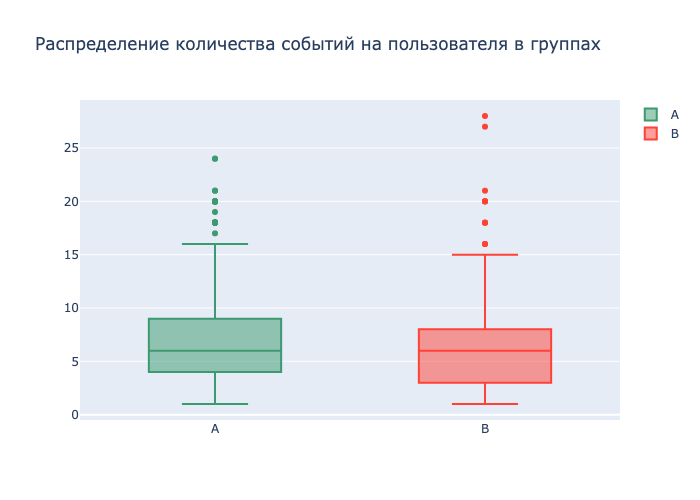

In [60]:
# визуализируем результаты с помощью диаграммы рассеяния
fig = go.Figure()

fig.add_trace(go.Box(
    y=actions_A['event_name'],
    name='A',
    marker_color='#3D9970'
))
fig.add_trace(go.Box(
    y=actions_B['event_name'],
    name='B',
    marker_color='#FF4136'
))

fig.update_layout(title=dict({'text': 'Распределение количества событий на пользователя в группах'}))

Количество событий на пользователя почти равно распределены в выборках:
* Среднее количество событий в группе A - 6, в группе B - 5.
* Минимальное количество - 1 событие. То есть у нас нет тех пользователей, кто не совершил ни одного действия.
* Максимальное количество - 24 события.

**Как число событий в выборках распределено по дням?**

Так как в предыдущих шагах мы отсекали события старше 14 дней с момента регистрации, рассмотрим еще раз диаграмму распределения количества событий в выборках по дням.

In [61]:
# формируем группы
groupA = eu_events[eu_events['group']=='A']
groupB = eu_events[eu_events['group']=='B']

In [62]:
# считаем количество событий в день в каждой группе
actions_per_dayA = groupA.groupby('event_dt')['event_name'].count().to_frame().reset_index()
actions_per_dayB = groupB.groupby('event_dt')['event_name'].count().to_frame().reset_index()

In [63]:
# объединяем две группы в одну табличку
actions_per_day = actions_per_dayA.merge(actions_per_dayB, on='event_dt')
actions_per_day.columns = ['date', 'group_A', 'group_B']
actions_per_day

,date,group_A,group_B
0,2020-12-07,221,268
1,2020-12-08,239,169
2,2020-12-09,282,250
3,2020-12-10,246,182
4,2020-12-11,264,115
5,2020-12-12,273,150
6,2020-12-13,233,103
7,2020-12-14,755,193
8,2020-12-15,780,164
9,2020-12-16,748,275


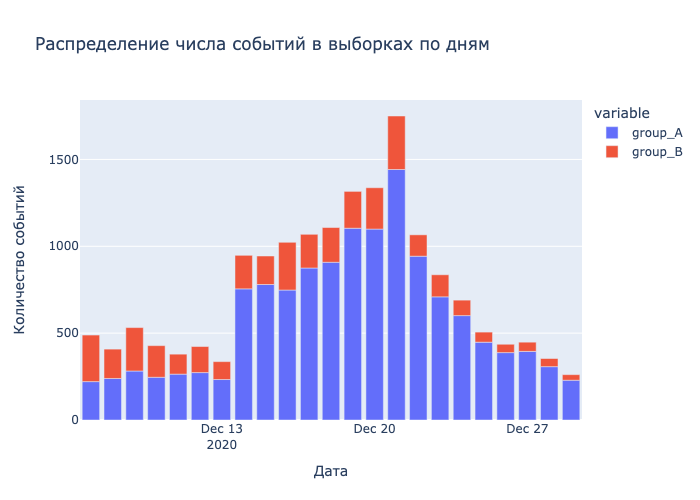

In [64]:
fig = px.bar(actions_per_day, x="date", y=["group_A", "group_B"], title="Распределение числа событий в выборках по дням",
            labels={'value': 'Количество событий', 'date': 'Дата'})
fig.show()

Мы рассмотрели количество событий в выборках по дням, и вот, что выяснили:

* Несмотря на то, что пользователей в группе А больше, чем в группе В, в начале теста количество событий в группах было почти одинаковым.
* Мы заметили первый резкий скачок в количестве событий 14 декабря. В группе А в этот день почти в 4 раза было событий больше, чем в группе B.
* C 19 по 21 декабря количество событий в первой группе превышало события во второй группе в 5 раз.
* После 21 декабря в обоих выборках замечен спад.

**Как меняется конверсия в воронке в выборках на разных этапах?**

In [65]:
funnel = eu_events.groupby('event_name')['user_id'].nunique()\
                  .to_frame()\
                  .sort_values(by='user_id', ascending = False)\
                  .reset_index()
funnel

,event_name,user_id
0,login,2593
1,product_page,1632
2,purchase,804
3,product_cart,773


По нашим данным мы видим, что события не выстраиваются в логичном порядке.
Порядок событий должен быть таким:

1. login - регистрация
2. product_page - просмотр страницы продукта
3. product_cart - добавление в корзину
4. purchase - покупка 

Какие-то пользователи перешли на этап покупки до добавления в корзины. Скорее всего это связано с тем, что приобрести товары можно в обход корзины (например, были совершены быстрые покупки без корзины).

**Построим воронку в логичной последовательности и оценим конверсию переходов**

In [66]:
events_group = eu_events.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique')\
                          .sort_values('A',ascending=False)
events_group = events_group.reset_index()
events_group

group,event_name,A,B
0,login,1939,654
1,product_page,1265,367
2,purchase,613,191
3,product_cart,589,184


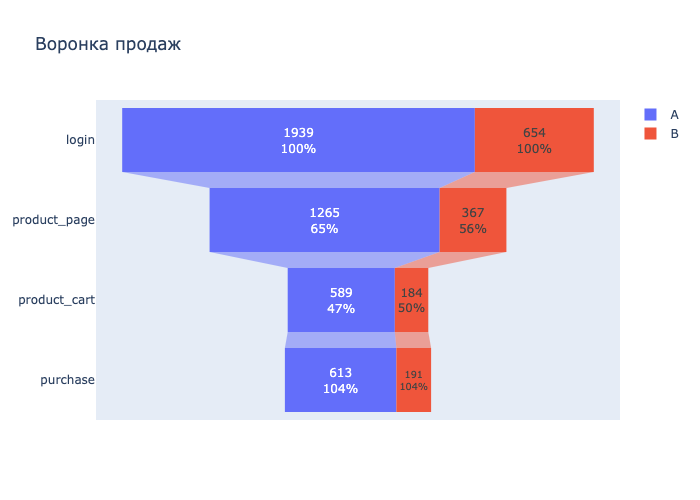

In [67]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = ['login', 'product_page', 'product_cart', 'purchase'],
    x = [1939, 1265, 589, 613],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ['login', 'product_page', 'product_cart', 'purchase'],
    x = [654, 367, 184, 191],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title=dict({'text': 'Воронка продаж'}))
fig.show()

По воронке конверсии в целевое действие мы видим, что: 
- Больше половины пользователей переходит после регистрации на страницу продукта (в группе А - 65%, в группе В - 56%).
- От просмотра продукта в корзину в группе А переходит 47% пользователей, а в группе В - 50%.
- Количество покупок превышает количество переходов в корзину. От корзины к покупке в обоих группах переходит 104% пользователей. В обоих случаях - это почти 14% от зарегистрировавшихся пользователей.

Ожидаемый эффект от теста - за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

- конверсии в просмотр карточек товаров — событие `product_page`: в группе В конверсия на 9% меньше, чем в группе А.
- конверсии в просмотр карточек товаров — событие `product_cart`: в группе В конверсия на 3% больше, чем в группе А.
- покупки — `purchase`: конверсия в обоих группах почти одинаковая.

**Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?**

Мы провели проверку экспериментальных групп - в наших группах только пользователи из Евросоюза, они не пересекаются между группами нашего теста и не пересекаются с конкурирующим тестом.

В итоге у нас осталось 2593 пользователей:

* в группе A 1939 пользователей
* в группе B 655 пользователей

Количество пользователей во второй группе почти в 2,8 раз меньше, чем в первой группе. Наши группы неравномерны, сформированы некорректно. Мощности теста недостаточно, выборки должны быть по 3360 человек в каждой группе. Это отразится на результате тестирования.

## 4. Оценим результаты A/B-тестирования

Проверим гипотезу о том, что конверсия увеличилась с внедрением улучшенной рекомендательной системы на каждом этапе.

In [68]:
# функция для z-теста
def z_test(successes1, successes2, trials1, trials2, alpha):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = stats.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)
 
    if (p_value < alpha): 
        print('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [69]:
# посчитаем количество пользователей в группах
trials1 = groupA['user_id'].nunique() # группа А
trials2 = groupB['user_id'].nunique() # группа B

Так как далее у нас будет несколько сравнений, воспользуемся методом Бонферрони. Будем делить уровень значимости 0.05 на общее количество сравнений (у нас их будет 3).

**z-тест конверсии в product_page**

H0 - конверсия группы А на этапе product_page равна конверсии группы В\
H1 - конверсии групп не равны

In [70]:
# посчитаем количество успехов - конверсия в product_page
successes1 = events_group['A'][1]
successes2 = events_group['B'][1]

In [71]:
z_test(successes1, successes2, trials1, trials2, 0.05/3)

p-значение:  2.457788807452843e-05
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


**z-тест конверсии в product_cart**

H0 - конверсия группы А на этапе product_cart равна конверсии группы В\
H1 - конверсии групп не равны

In [72]:
# посчитаем количество успехов - конверсия в product_cart
successes1 = events_group['A'][3]
successes2 = events_group['B'][3]

In [73]:
z_test(successes1, successes2, trials1, trials2, 0.05/3)

p-значение:  0.26899325584838074
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет


**z-тест конверсии в purchase**

H0 - конверсия группы А на этапе purchase равна конверсии группы В\
H1 - конверсии групп не равны

In [74]:
# посчитаем количество успехов - конверсия в purchase
successes1 = events_group['A'][2]
successes2 = events_group['B'][2]

In [75]:
z_test(successes1, successes2, trials1, trials2, 0.05/3)

p-значение:  0.24035836270660704
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет


Что можно сказать по результатам z-теста:
* Конверсия в просмотр продукта: между выборками есть статистически значимые различия. Группа А показала себя лучше, чем группа B.
* Конверсия в просмотр корзины: между выборками нет статистически значимых различий.
* Конверсия в покупку: между выборками нет статистически значимых различий.

Результат теста говорит о том, что группа В не показала себя лучше, чем группа А.

## Общие выводы

**Выводы по исследовательскому анализу:**
* Количество событий на пользователя почти равно распределены в выборках. В группе A - 6 событий, в группе B - 5.
* Исходя из того, что в группе А изначально больше пользователей, мы получили логичное распределение количества событий по дням. В группе A событий больше, чем в группе B. C 19 по 21 декабря количество событий в первой группе превышало события во второй группе в 5 раз.
* По воронке конверсии в целевое действие мы видим, что: 
    - Больше половины пользователей переходит после регистрации на страницу продукта (в группе А - 65%, в группе В - 56%).
    - От просмотра продукта в корзину в группе А переходит 47% пользователей, а в группе В - 50%.
    - Количество покупок превышает количество переходов в корзину. От корзины к покупке в обоих группах переходит 104% пользователей. В обоих случаях - это почти 14% от зарегистрировавшихся пользователей.

* Ожидаемый эффект от теста - за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page: в группе В конверсия на 9% меньше, чем в группе А.
    -конверсии в просмотр карточек товаров — событие product_cart: в группе В конверсия на 3% больше, чем в группе А.
    -покупки — purchase: конверсия в обоих группах почти одинаковая.

**Выводы по A/B тесту:**

* Конверсия в просмотр продукта: между выборками есть статистически значимые различия. Группа А показала себя лучше, чем группа B.
* Конверсия в просмотр корзины: между выборками нет статистически значимых различий.
* Конверсия в покупку: между выборками нет статистически значимых различий.

Итог: Результат теста говорит о том, что группа В не показала себя лучше, чем группа А.

Мы получили общие выводы, но их нельзя считать корректными. Различия в размерах выборок критичные, возможно, не отражающие реальную картину. Тест следует провести повторно, но на этот раз учесть время проведения маркетинговых активностей (тест не должен с ними пересекаться), наладить процессы фиксации пользователей и набрать нужное количество пользователей для корректного размера выборки.